In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.colors import LogNorm, Normalize
import matplotlib.ticker as mticker
from pathlib import Path
import json
from os import makedirs

In [7]:
path = '../final_results_graphs'
gp_path = f'{path}/grouped_bar'
heatmap_path = f'{path}/heatmap'
makedirs(gp_path, exist_ok=True)
makedirs(heatmap_path, exist_ok=True)
print(f"Directory '{path}' created or already existed.")

Directory '../final_results_graphs' created or already existed.


In [8]:
def plot_grouped_bar_charts(df_all_metrics, metrics_to_plot, log_scale_metrics=None):
    if log_scale_metrics is None:
        log_scale_metrics = []

    features = df_all_metrics['feature'].unique()
    models = df_all_metrics['model_name'].unique()
    
    for metric_name in metrics_to_plot:
        df_metric = df_all_metrics[df_all_metrics['metric'] == metric_name]
        
        if df_metric.empty:
            print(f"No data found for metric: {metric_name}")
            continue

        plt.figure(figsize=(max(12, 2 * len(features) * len(models) / 4), 8))
        
        plot = sns.barplot(x='feature', y='value', hue='model_name', data=df_metric, palette='viridis')

        plt.title(f'Model Comparison for {metric_name}', fontsize=16)
        plt.xlabel('Feature', fontsize=12)
        plt.ylabel(f'{metric_name} Value' + (' (Log Scale)' if metric_name in log_scale_metrics else ''), fontsize=12)
        plt.xticks(rotation=45, ha='right', fontsize=10)
        plt.yticks(fontsize=10)
        
        if metric_name in log_scale_metrics:
            plt.yscale('log')
            min_val = df_metric['value'][df_metric['value'] > 0].min()
            max_val = df_metric['value'].max()
            if pd.notna(min_val) and pd.notna(max_val) and min_val > 0 :
                 plt.ylim(bottom=min_val * 0.5, top=max_val * 1.5)
            elif pd.notna(max_val) and max_val > 0:
                 plt.ylim(top=max_val*1.5)


        plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout(rect=[0, 0, 0.85, 1]) 
        plt.savefig(f'{gp_path}/{metric_name}.png',dpi=300)
        plt.show()


In [9]:
def plot_heatmaps(df_all_metrics, metrics_to_plot, log_scale_metrics=None):
    if log_scale_metrics is None:
        log_scale_metrics = []

    for metric_name in metrics_to_plot:
        df_metric = df_all_metrics[df_all_metrics['metric'] == metric_name]
        
        if df_metric.empty:
            print(f"No data found for metric: {metric_name}")
            continue
            
        pivot_table = df_metric.pivot_table(index='model_name', columns='feature', values='value')

        if pivot_table.empty:
            print(f"Could not create pivot table for metric: {metric_name}")
            continue

        plt.figure(figsize=(max(10, 1.2 * len(pivot_table.columns)), max(6, 0.8 * len(pivot_table.index))))
        
        norm = None
        fmt = ".2f"
        if metric_name in log_scale_metrics:
            valid_data = pivot_table.unstack()
            valid_data = valid_data[valid_data > 0]
            if not valid_data.empty:
                min_val = valid_data.min()
                max_val = valid_data.max()
                if min_val == max_val : # if all values are the same, LogNorm fails
                    norm = Normalize(vmin=min_val*0.9 if min_val > 0 else -0.1, vmax=max_val*1.1 if max_val > 0 else 0.1)
                else:
                    norm = LogNorm(vmin=min_val, vmax=max_val)
                fmt = ".1e"
            else: # All values are zero or negative, LogNorm not applicable
                norm = Normalize(vmin=pivot_table.min().min(), vmax=pivot_table.max().max())


        is_r2 = metric_name == "R2"
        cmap = "viridis_r" if not is_r2 else "viridis" # _r reverses colormap, good for errors (lower is better)
        
        sns.heatmap(pivot_table, annot=True, fmt=fmt, cmap=cmap, linewidths=.5, norm=norm, cbar_kws={'label': f'{metric_name} Value' + (' (Log Scale)' if norm.__class__ == LogNorm else '')})
        plt.title(f'Heatmap of {metric_name} by Model and Feature', fontsize=16)
        plt.xlabel('Feature', fontsize=12)
        plt.ylabel('Model', fontsize=12)
        plt.xticks(rotation=45, ha='right', fontsize=10)
        plt.yticks(rotation=0, fontsize=10)
        plt.tight_layout()
        plt.savefig(f'{heatmap_path}/{metric_name}.png',dpi=300)
        plt.show()

Dados carregados com sucesso para o modelo: NHiTS de ../results/NHiTS/best_metrics.json
Dados carregados com sucesso para o modelo: LightGBM de ../results/LightGBM/best_metrics.json
Dados carregados com sucesso para o modelo: XGB de ../results/XGB/best_metrics.json
Dados carregados com sucesso para o modelo: Transformer de ../results/Transformer/best_metrics.json
Dados carregados com sucesso para o modelo: TFT de ../results/TFT/best_metrics.json
Dados carregados com sucesso para o modelo: GRU de ../results/GRU/best_metrics.json
Dados carregados com sucesso para o modelo: TSMixer de ../results/TSMixer/best_metrics.json
Dados carregados com sucesso para o modelo: LSTM de ../results/LSTM/best_metrics.json
Dados carregados com sucesso para o modelo: TCN de ../results/TCN/best_metrics.json

Gerando Gráficos de Barras Agrupadas...


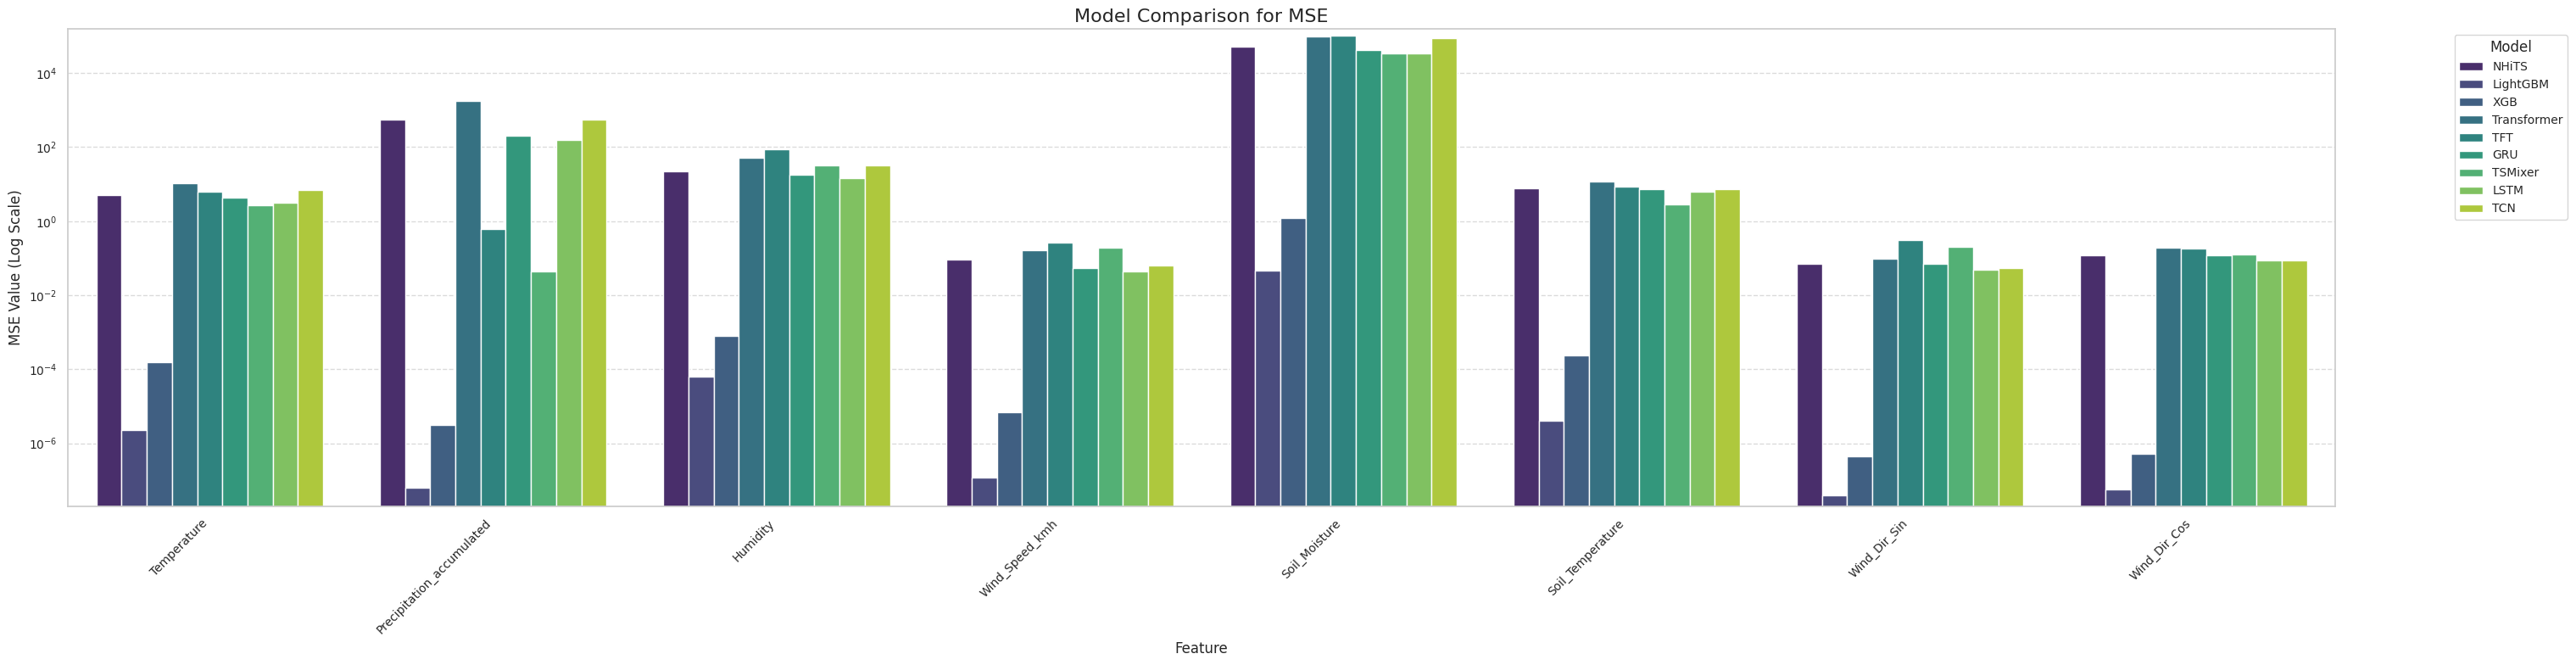

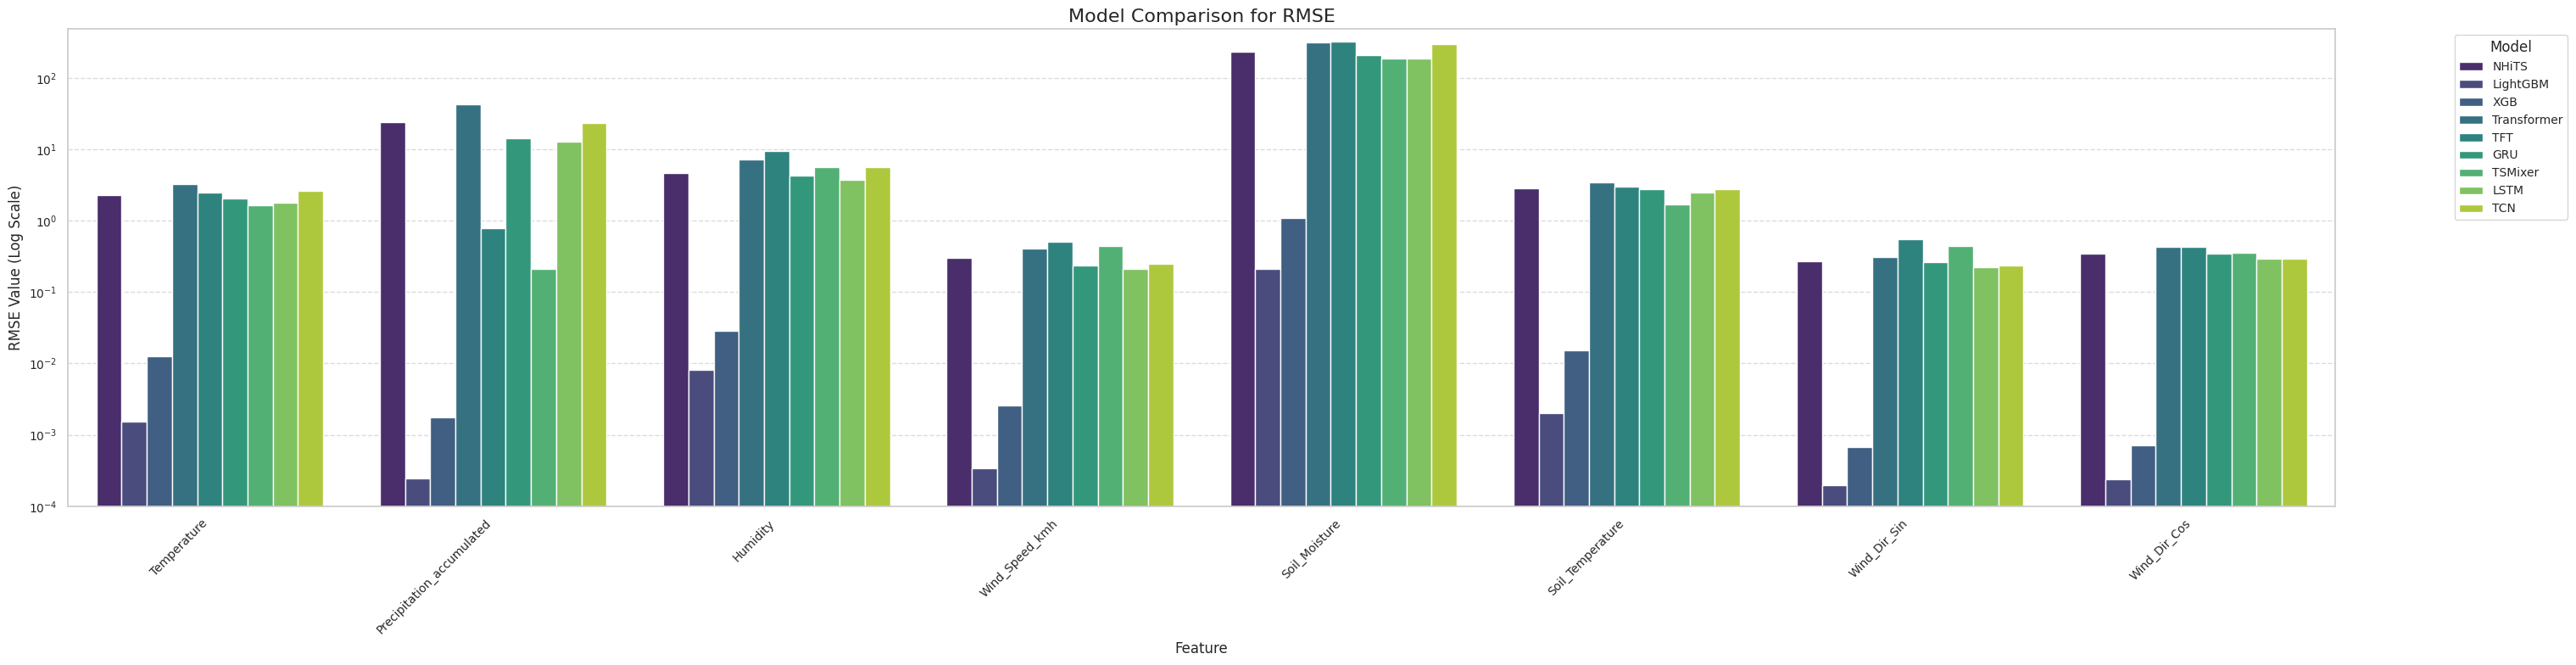

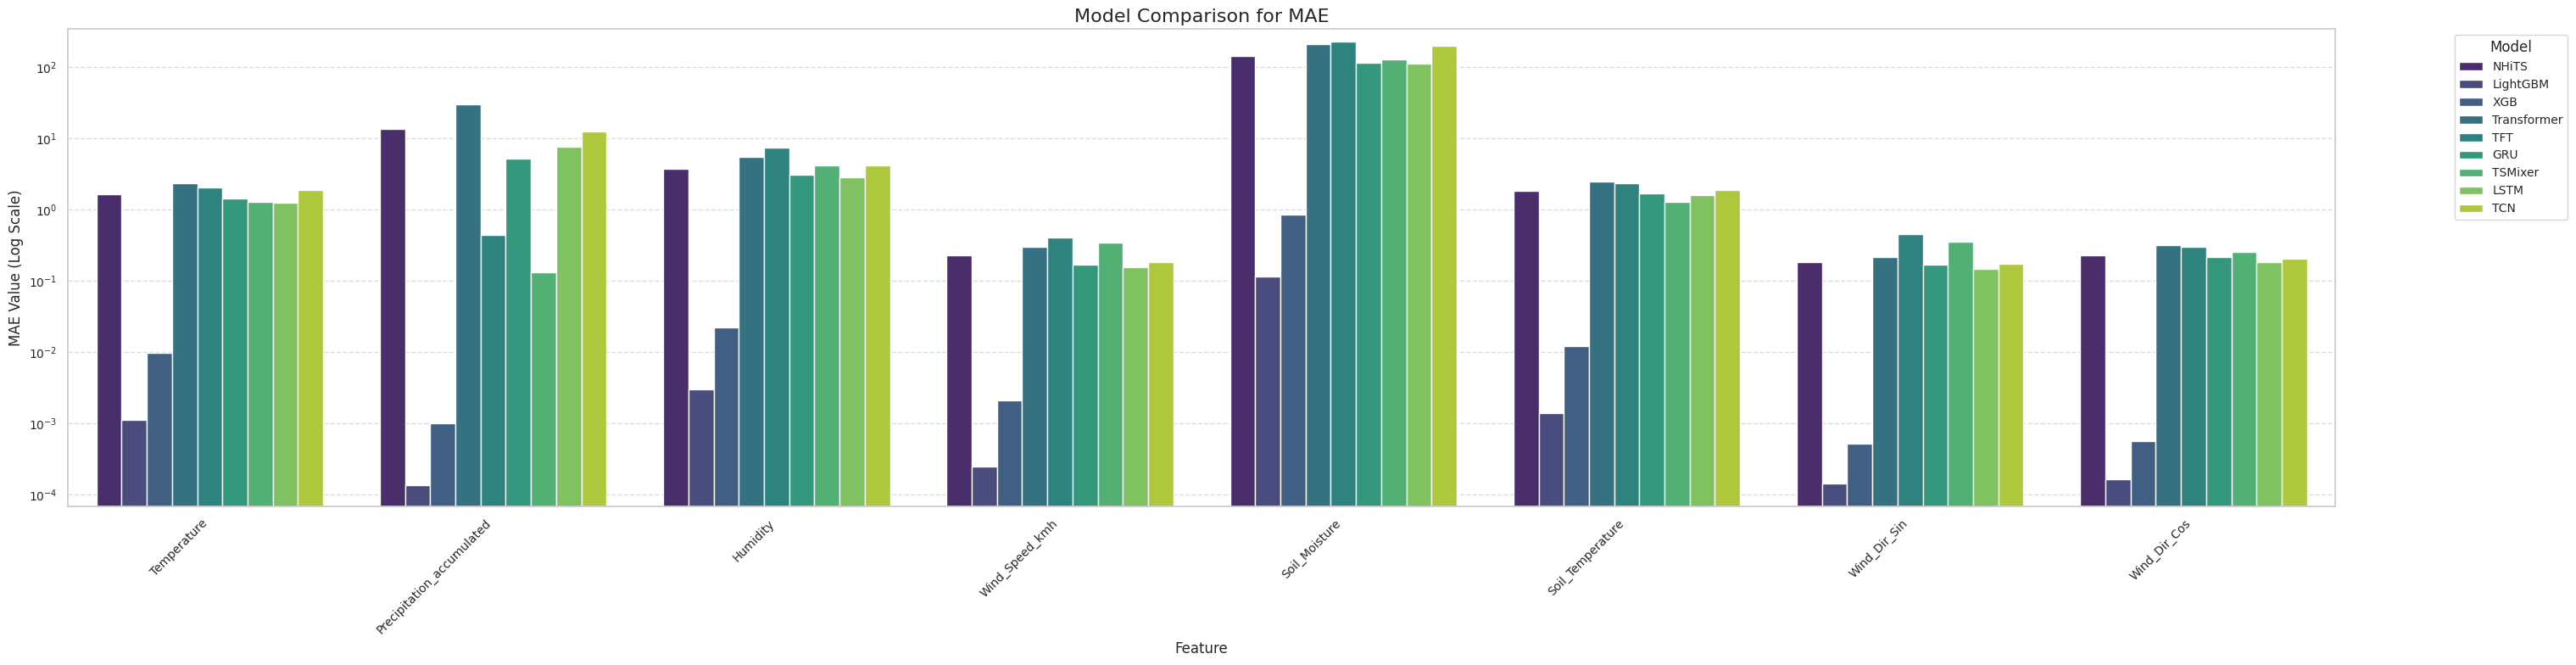

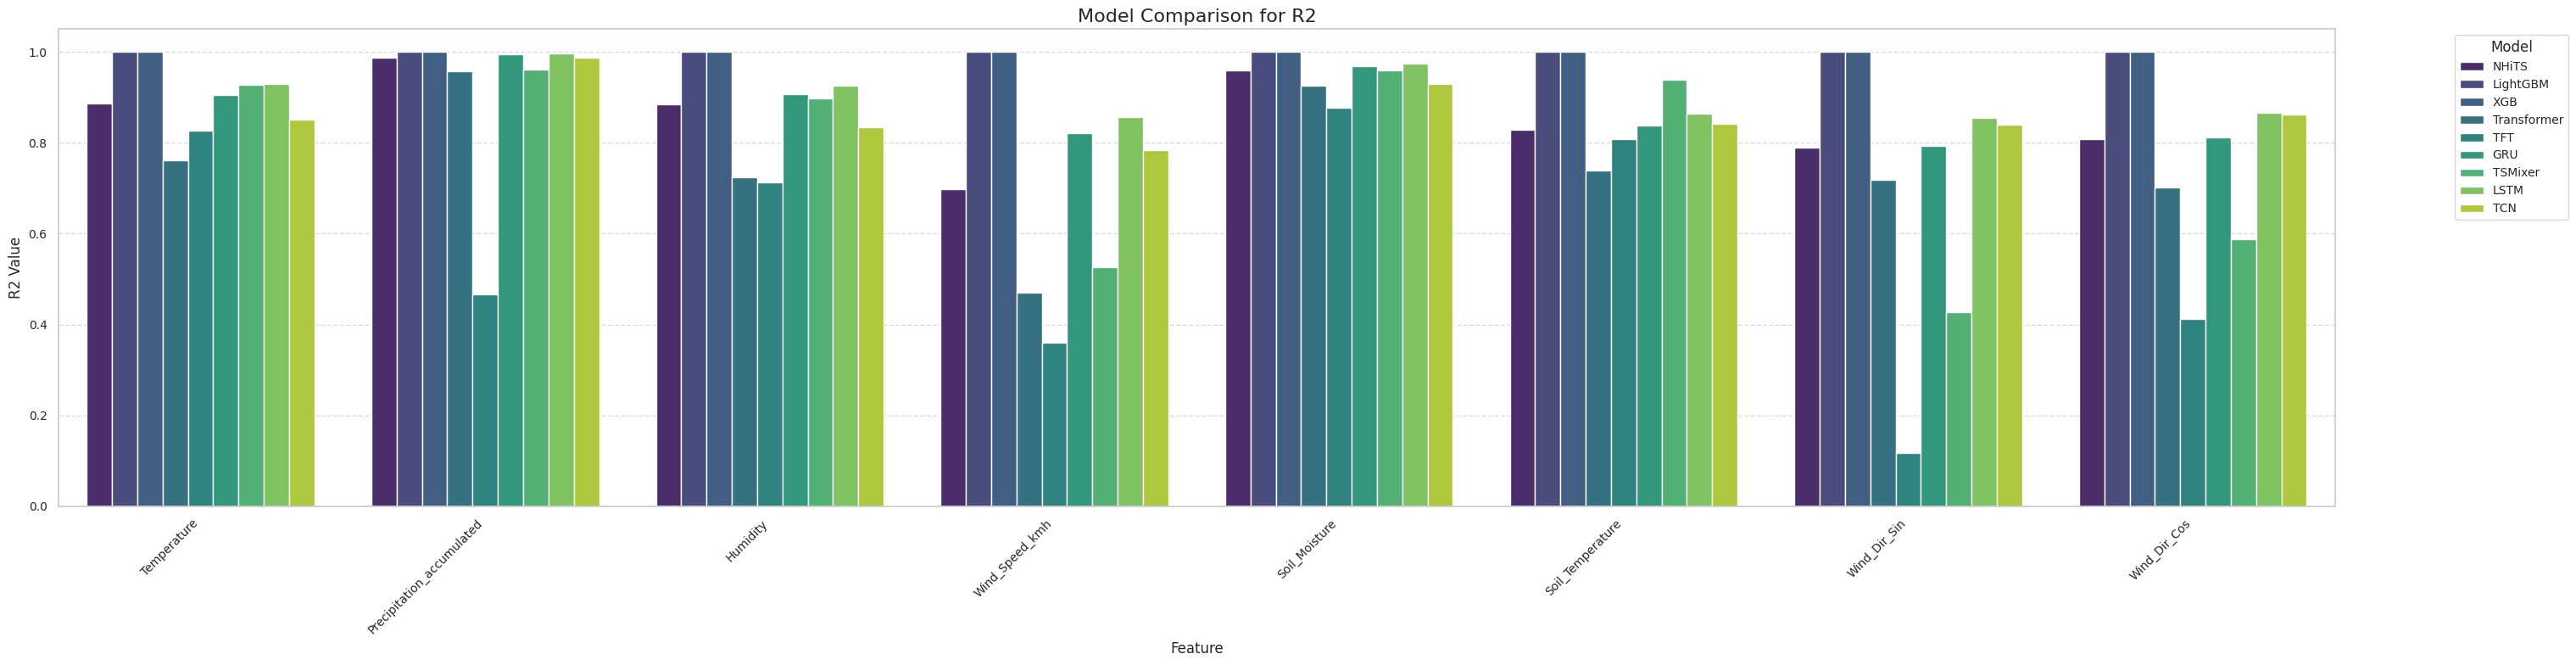

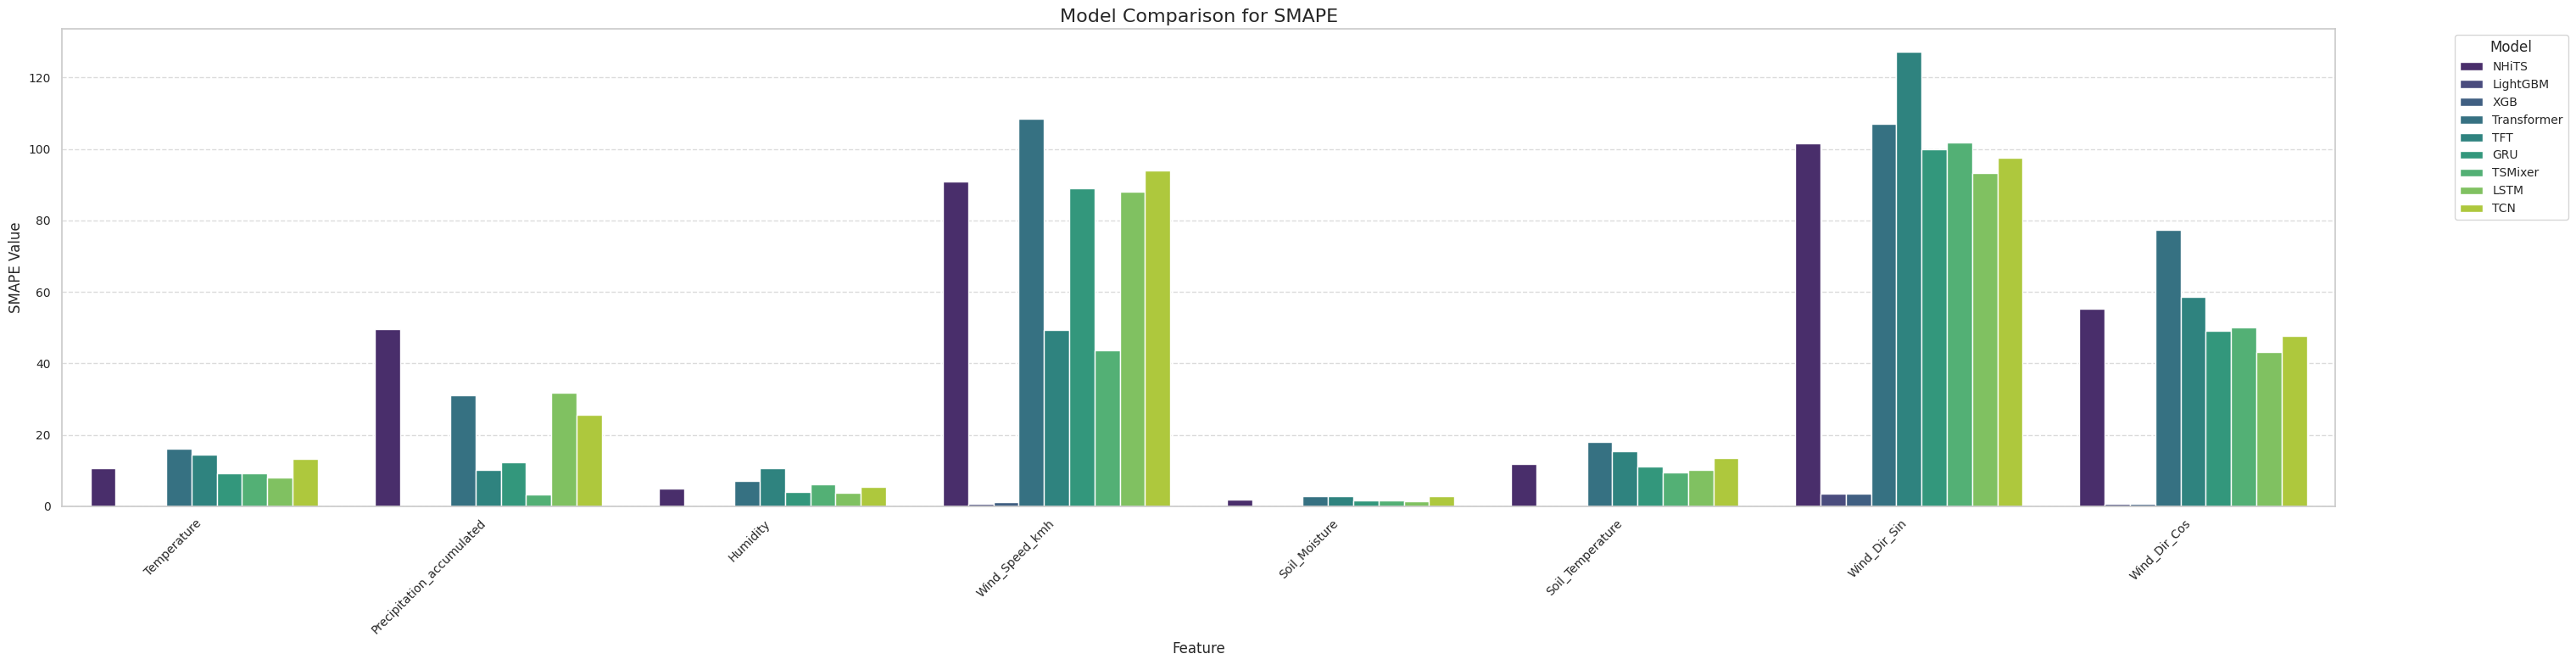


Gerando Mapas de Calor (Heatmaps)...


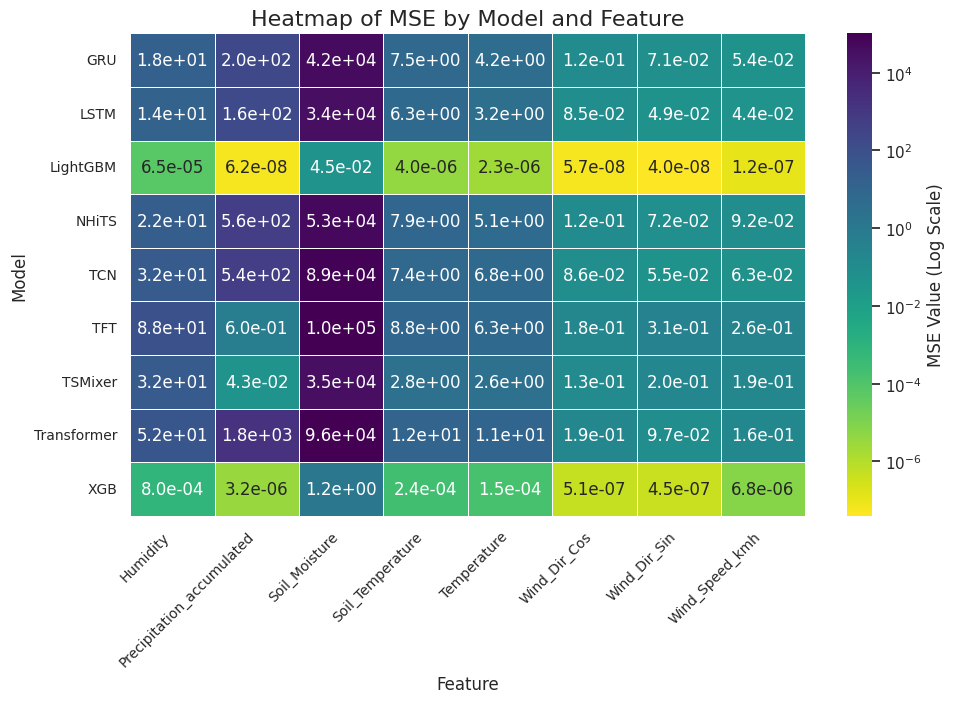

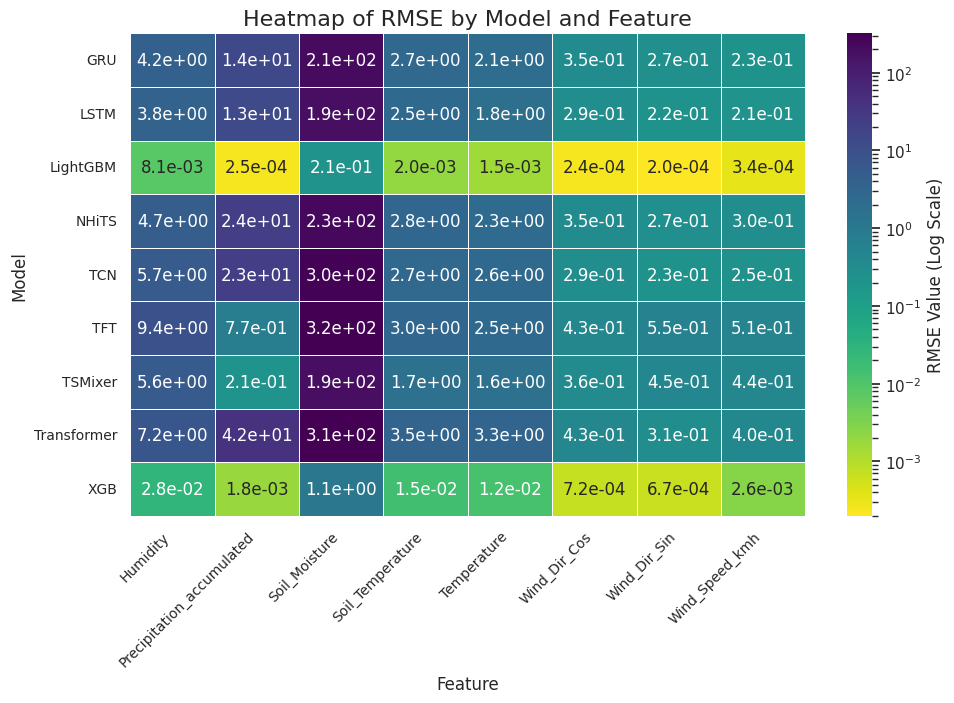

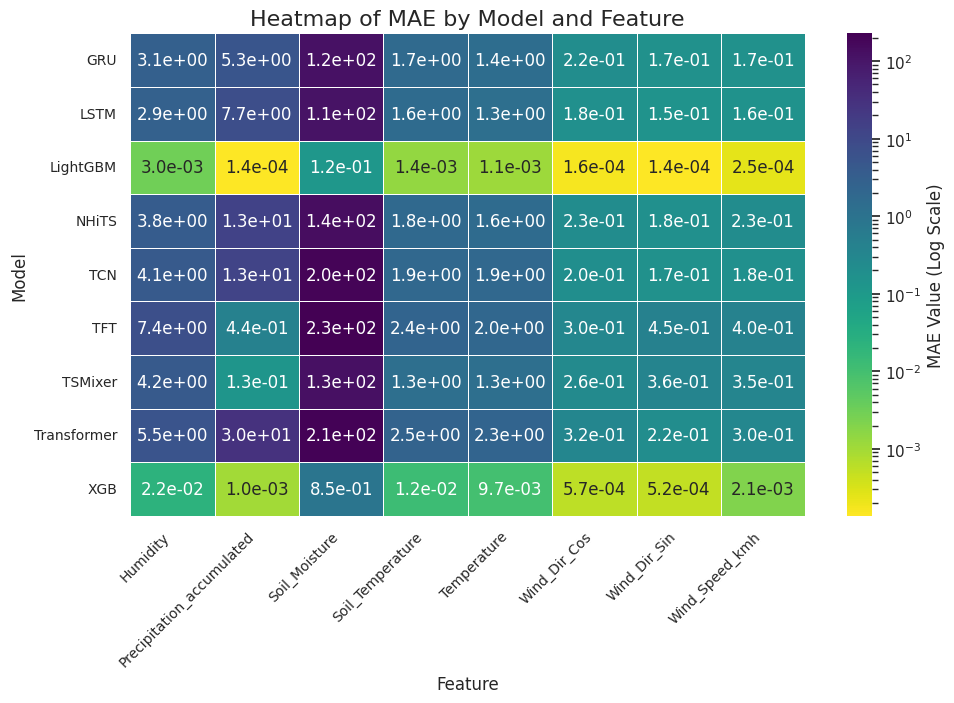

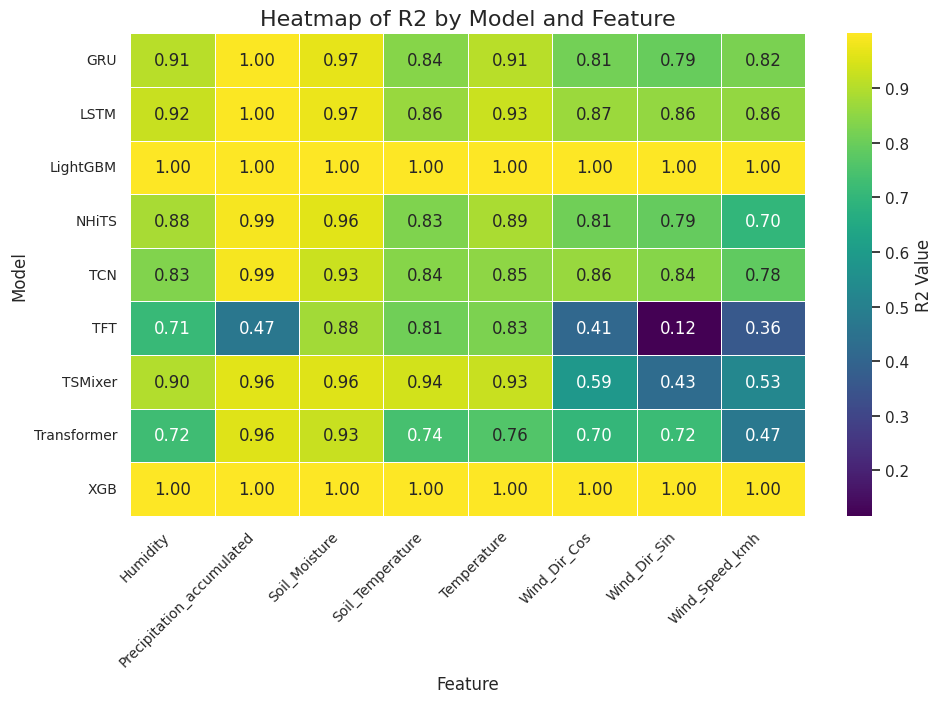

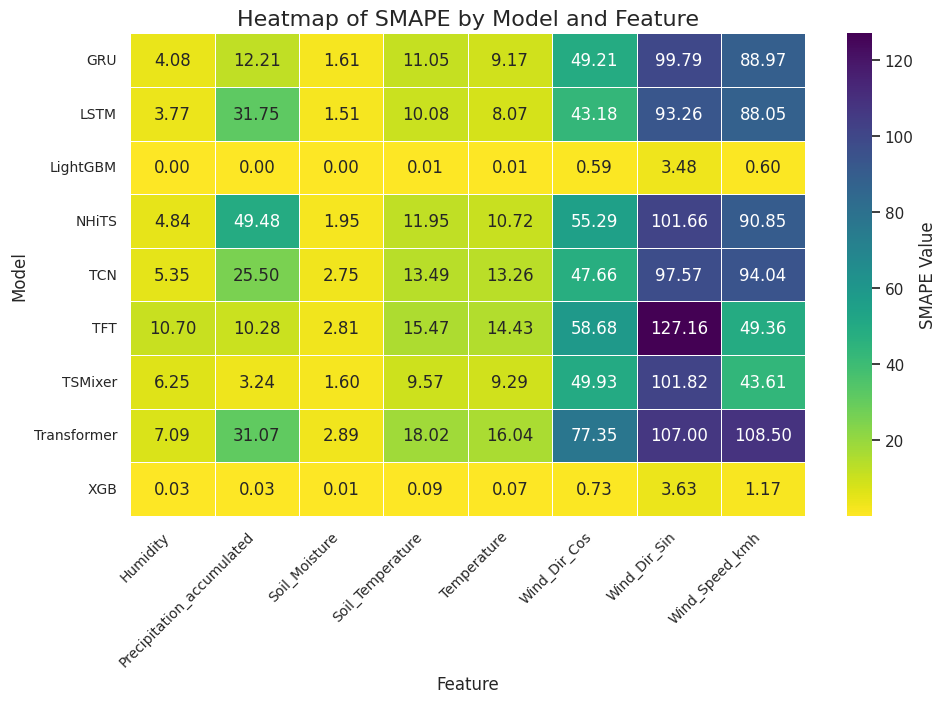

In [10]:
base_dir = Path('../results') # Base directory for results
userdata = [] # This list will hold data from all models

subdirs = [d for d in base_dir.iterdir() if d.is_dir()]

for model_dir in subdirs:
    model_name = model_dir.name  # Use the directory name as the model name
    json_file_path = model_dir / 'best_metrics.json' # Path to the JSON file

    if json_file_path.exists() and json_file_path.is_file():
        try:
            with open(json_file_path, 'r', encoding='utf-8') as f:
                metrics_data = json.load(f)
            
            # Basic validation of metrics_data structure
            if not isinstance(metrics_data, dict):
                print(f"Aviso: O conteúdo de '{json_file_path}' não é um dicionário. Pulando modelo {model_name}.")
                continue

            userdata.append({
                "model_name": model_name,
                "metrics": metrics_data 
            })
            print(f"Dados carregados com sucesso para o modelo: {model_name} de {json_file_path}")
        except json.JSONDecodeError:
            print(f"Erro ao decodificar JSON de {json_file_path} para o modelo {model_name}. Verifique o formato do arquivo.")
        except Exception as e:
            print(f"Ocorreu um erro ao processar {json_file_path} para o modelo {model_name}: {e}")
    else:
        print(f"Aviso: 'best_metric.json' não encontrado em {model_dir}. Pulando este diretório.")


records = []
for item in userdata:
    model_name = item['model_name']
    # Ensure 'metrics' key exists and is a dictionary
    if 'metrics' in item and isinstance(item['metrics'], dict):
        for metric_name, feature_dict in item['metrics'].items():
            if isinstance(feature_dict, dict):
                for feature_name, value in feature_dict.items():
                    records.append({
                        'model_name': model_name,
                        'metric': metric_name,
                        'feature': feature_name,
                        'value': value
                    })
            else:
                print(f"Aviso: Esperava-se um dicionário para features sob a métrica '{metric_name}' para o modelo '{model_name}', mas obteve {type(feature_dict)}")
    else:
        print(f"Aviso: Dados de 'metrics' ausentes ou inválidos para o modelo '{model_name}'")


df_all_metrics = pd.DataFrame(records)


all_metric_names = df_all_metrics['metric'].unique()
log_scale_for_these_metrics = ["MSE", "RMSE", "MAE"] # Metrics that benefit from log scale

sns.set_theme(style="whitegrid") # Sets a nice default theme for plots

print("\nGerando Gráficos de Barras Agrupadas...")
plot_grouped_bar_charts(df_all_metrics, all_metric_names, log_scale_metrics=log_scale_for_these_metrics)

print("\nGerando Mapas de Calor (Heatmaps)...")
plot_heatmaps(df_all_metrics, all_metric_names, log_scale_metrics=log_scale_for_these_metrics)